# Machine Learning for metabolomes of microbial communities

In [1]:
# imports
import mat73
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

## Re-defining tables

In [2]:
from helpers import *
for file in parse_folder("../data/guts"):
    if file.endswith(".mat"):
        mat_to_tsv("../data/guts", file)

## Loading in

In [3]:
# Load matrices
strains = pd.read_csv("../data/guts/strains.tsv", sep="\t")
comm8 = pd.read_csv("../data/guts/comm8.tsv", sep="\t")
metData = pd.read_csv("../data/guts/metData.tsv", sep="\t")
metData.index = pd.read_csv("../data/guts/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("../data/guts/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../data/guts/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")

## Combination

In [4]:
def join_df_metNames(df):
    cols = ["metNames"] + [f"MS{i+1}" for i in range(len(df.columns) - 6)]
    comb = pd.DataFrame(columns=cols)
    for pid in df["peakID"].unique():
        comb_met_name = ""
        for met_name in df.loc[df["peakID"] == pid]["MetName"]:
            comb_met_name += met_name + "\n"
        comb.loc[len(comb.index)] = [comb_met_name[:-2]] + list(df.loc[df["peakID"] == pid].iloc[0, 6:])
    comb = comb.set_index('metNames')
    return comb

## Normalization

In [5]:
def standard_normalization(df, axis=1):
    return df.apply(lambda line: [(x - np.mean(line)) / np.var(line) for x in line], result_type="expand", axis=axis)

## Data preparation

In [6]:
met_raw_comb = pd.concat( [standard_normalization( join_df_metNames(met_raw_pos) ), standard_normalization( join_df_metNames(met_raw_neg) )] )

## Method definitions 

In [7]:
def mult_cv_model(model, X, ys, n_fold):
    """
    Performs model training and cross-validation over each column
    """
    # Matrices for report
    accuracies = []
    confusion_matrices = []
    
    # Perform cross-validation for each strain separately
    for y in ys.transpose():

        # Predict the test set labels
        y_pred = cross_val_predict(model, X.transpose(), y, cv=n_fold)

        confusion_matrices.append(confusion_matrix(y, y_pred))
        accuracies.append(accuracy_score(y,y_pred))
    return (accuracies, confusion_matrices)

In [8]:
def plot_cv_confmat(ys, target_labels, accuracies, confusion_matrices, outdir, name):
    """
    Plot heatmap of confusion matrix
    """
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 8))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    for i, ax in enumerate(axs.flat):
        sns.heatmap(confusion_matrices[i], 
                    vmin=0, vmax=len(ys), annot=True, ax=ax, 
                    cbar=i == 0, cbar_ax=None if i else cbar_ax)
        ax.set_title(f'{target_labels[i]}, Accuracy: {round(accuracies[i], 5)}')
        ax.axis('off')
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f"{outdir}/{name}.png")
    plt.close()
    

## Learning and tuning

### SVM

### Neural Network

In [11]:
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect*")

# Parameters
X = metData
ys = comm8
seed = 42
n_fold = 5
maximum_iterations = 1000
outdir = "../reports"
suffix = ""
target_labels = strains.values
param_grid = [
  { 'solver': ['adam'],
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    "hidden_layer_sizes": [(500, 100), (100, 100), (20, 100), (100, 20), (500, 20)],
    activation_functions = ["identity", "logistic", "relu"]},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'solver': ['rbf']},
 ]
layer_sizes = [(500, 100, 100, 100, 100, 100)]

# Evaluation data
results = pd.DataFrame(columns=["model_nr", "parameters", "target", "accuracy"])

model_count = 1
for seed in seeds:
    for solver in solvers:
        for layer_size in layer_sizes:
            for alpha in alphas:
                for act_f in activation_functions:
                    # Model definition
                    model = MLPClassifier(activation=act_f, solver=solver, alpha=alpha, hidden_layer_sizes=layer_size, random_state=seed, max_iter=maximum_iterations)

                    accuracies, confusion_matrices = mult_cv_model(model=model, X=np.array(X), ys=np.array(ys), n_fold=n_fold)
                    for i in range(len(target_labels)):
                        results.loc[len(results.index)] = [model_count, [act_f, solver, alpha, layer_size], target_labels[i], accuracies[i], ]

                    model_count += 1
                    name = f"/mlp/conf_mats/nn_af:{act_f}_solver:{solver}_size:{layer_size}_alpha:{alpha}{suffix}"
                    plot_cv_confmat(ys=ys, target_labels=target_labels, accuracies=accuracies, confusion_matrices=confusion_matrices, outdir=outdir, name=name)

results.to_csv(f"{outdir}/mlp/accuracies_nn{suffix}.tsv",sep="\t")

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect*")



# Parameters
X = metData
ys = comm8
seeds = [42, 128]
n_folds = 6
outdir = "../reports"
suffix = ""
target_labels = strains.values
ccp_alphas = np.arange(0, 0.5, 0.025)


# Evaluation data
results = pd.DataFrame(columns=["seed", "ccp_alpha", "target", "accuracy",  "model_nr"])

model_count = 1
for seed in seeds:
    for ccp_alpha in ccp_alphas:
        # Model definition
        model = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=seed)

        accuracies, confusion_matrices = mult_cv_model(model=model, X=np.array(X), ys=np.array(ys), n_fold=n_fold)
        for i in range(len(target_labels)):
            results.loc[len(results.index)] = [seed, ccp_alpha, target_labels[i], accuracies[i], model_count]

        model_count += 1
        name = f"/decisiontree/conf_mats/cm_seed:{seed}_ccp_alpha:{round(ccp_alpha, 3)}{suffix}"
        plot_cv_confmat(ys=ys, target_labels=target_labels, accuracies=accuracies, confusion_matrices=confusion_matrices, outdir=outdir, name=name)

results.to_csv(f"{outdir}/decisiontree/accuracies_decision_tree{suffix}.tsv",sep="\t")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Parameters
X = metData
ys = comm8
seeds = [42, 128]
n_fold = 6
n_trees = [10, 100, 400]
max_depths = [None, 5, 20]
outdir="../reports"
suffix = ""
target_labels = strains.values

# Evaluation data
results = pd.DataFrame(columns=["seed", "n_trees", "max_depth", "target", "accuracy", "model_nr"])

for seed in seeds:
    for n_tree in n_trees:
        for max_depth in max_depths:
            # Model definition
            rfc = RandomForestClassifier(n_estimators=n_tree, max_depth=max_depth, random_state=seed)

            accuracies, confusion_matrices = mult_cv_model(model=rfc, X=X, ys=ys, n_fold=n_fold)
            for i in range(len(target_labels)):
                results.loc[len(results.index)] = [seed, n_tree, max_depth, target_labels[i], accuracies[i], i]

            name = f"/conf_mats/cm_seed:{seed}_trees:{n_tree}_depth:{max_depth}{suffix}"
            plot_cv_confmat(ys=ys, target_labels=target_labels, accuracies=accuracies, confusion_matrices=confusion_matrices, outdir=outdir, name=name)

results.to_csv(f"{outdir}/accuracies_{seeds}_{n_trees}_{max_depths}{suffix}.tsv",sep="\t")


In [ ]:
results

,seed,ccp_alpha,target,accuracy,model_nr
0,42,0.000,C. ramosum,0.985294,1
1,42,0.000,R. gnavus,0.955882,1
2,42,0.000,C. aerofaciens,0.985294,1
3,42,0.000,B. thetaiotaomicron,0.897059,1
4,42,0.000,B. uniformis,0.617647,1
...,...,...,...,...,...
315,128,0.475,B. thetaiotaomicron,0.676471,40
316,128,0.475,B. uniformis,0.588235,40
317,128,0.475,B. vulgatus,0.911765,40
318,128,0.475,F. nucleatum,0.632353,40


## Analyis

In [ ]:
# results = pd.read_csv("../reports/accuracies_[42, 128]_[10, 100, 400]_[None, 5, 20].tsv", sep="\t", index_col="Unnamed: 0").fillna(0)

<Axes: xlabel='ccp_alpha', ylabel='accuracy'>

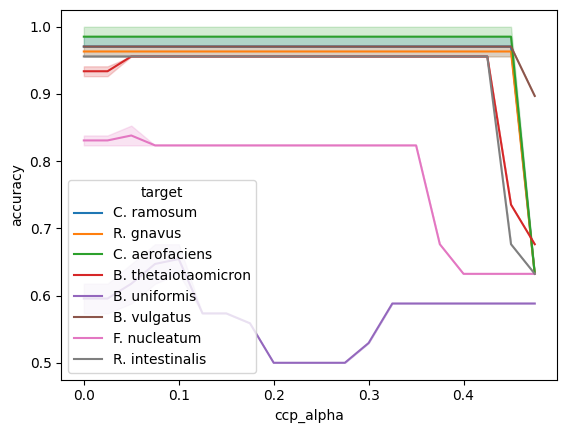

In [ ]:
sns.lineplot(data=results, y="accuracy", x="ccp_alpha", hue="target")

<Axes: xlabel='ccp_alpha', ylabel='accuracy'>

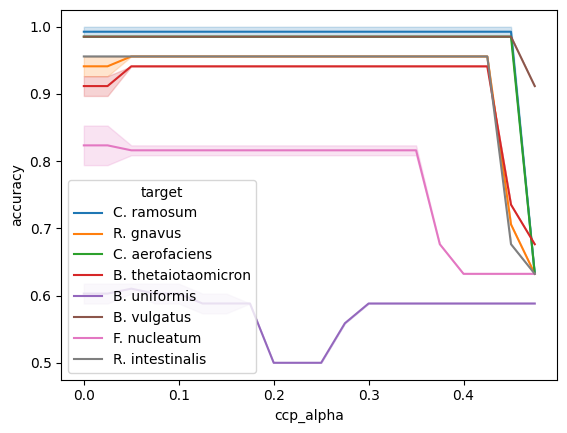

In [ ]:
sns.lineplot(data=results, y="accuracy", x="ccp_alpha", hue="target")

## In-depth analysis

In [ ]:
def plot_decision_trees(model, feature_names, class_names, outdir, name):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=900)
    tree.plot_tree(model,
                feature_names = feature_names, 
                class_names = class_names,
                filled = True)
    plt.savefig(f'{outdir}/{name}.png')
    plt.close()

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# for i, estimator in enumerate(model.estimators_):
for i, s in enumerate(strains):
    model.fit(X.transpose(),ys.transpose()[i])
    plot_decision_trees(model=model, feature_names=X.index, class_names=["absent", s], outdir=outdir, name=f"decisiontree/tree_{s}{suffix}")